In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
from pathlib import Path
import json

%matplotlib inline

In [97]:
output_path = os.path.join(str(Path.home()), "sync", "ada")

In [98]:
# available dataset results
os.listdir(output_path)

['toy 3 blobs',
 'MNIST -> USPS',
 'toys_app',
 'Amazon -> Webcam',
 'toy 2 moons',
 'MNIST -> SVHN',
 'MNIST -> MNIST-M']

In [122]:
dataset_name = "toy 2 moons"

## Checkout which configs have been used for the selected dataset

In [158]:
with open(os.path.join(output_path, dataset_name, "parameters.json"), "r") as fd:
    configs = json.load(fd)

In [159]:
def flatten_config(config):
    flat_conf = {}
    for k, v in config.items():
        if isinstance(v, list):
            flat_conf[k] = str(v)
        elif not isinstance(v, dict):
            flat_conf[k] = v
        else:
            v_dict = flatten_config(v)
            for ki, vi in v_dict.items():
                flat_conf[f"{ki}"] = vi
    return flat_conf

hash_flat_configs = {h: flatten_config(v) for h, v in configs.items()}

In [160]:
params_df = pd.DataFrame.from_dict(hash_flat_configs).T

### Print a summary of the experiment results avaible

- keep only parameters which are not duplicated over all experiments
- show experiment hashes with corresponding parameters

Use the dataframe showed below to select which experiments/parameters you want to keep in your analysis.

In [161]:
useful_params = []
for param in params_df.columns:
    if params_df.duplicated([param]).sum() < len(params_df) - 1:
        useful_params.append(param)


config_summary = params_df[useful_params]
config_summary

,adapt_lr,lambda_init,nb_adapt_epochs,nb_init_epochs,type,betas,proba_classes,data_seed,momentum,nesterov
6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
a779d77ee1098f2fc82a60eafde1d7d0,False,1,50,10,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
c3e2c19056235bffc081e3bc512dc082,False,1,100,10,Adam,"[0.8, 0.999]",0.7,87639,NaN,NaN
a44d051dcf8ae5cdf6cb4dbc5134d02b,False,1,100,10,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
4291fcf03e83d48fe218b9795945afe7,False,1,500,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
1c32ba6fcdcca7c13649689d69ae147d,False,2,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
b4a2e816b9902b315d11422c81d1713e,True,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True


### Compare UDA methods for a given set of hyperparameters

In [167]:
keep_hashes_list = ["b966242a3f1fb58e8aa9c3ae47be1e44"]

In [168]:
dfs = []
for h in keep_hashes_list:
    res = pd.read_csv(os.path.join(output_path, dataset_name, f"{h}.csv"), index_col=0)
    res["h"] = h
    res = res.merge(params_df[useful_params], left_on="h", right_index=True)
    dfs.append(res)

df = pd.concat(dfs)
df.head()

,source acc,target acc,seed,method,split,h,adapt_lr,lambda_init,nb_adapt_epochs,nb_init_epochs,type,betas,proba_classes,data_seed,momentum,nesterov
0,0.937500,0.937500,74894,WDGRL,Validation,b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True
1,0.951389,0.743056,74894,WDGRL,Test,b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True
2,0.937500,0.937500,74894,WDGRL (b=2),Validation,b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True
3,0.951389,0.743056,74894,WDGRL (b=2),Test,b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True
4,0.937500,0.937500,74894,WDGRL (b=4),Validation,b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True


In [169]:
test_results = df.query("split=='Test'")

Show a table with average and standard deviation of each method, sorting by increasing target accuracy.

In [170]:
test_results.groupby("method")[["source acc", "target acc"]]\
  .agg(["mean", "std"])\
  .sort_values(by=("target acc", "mean"), ascending=True)\
  .round(2)

source acc       target acc      
                   mean   std       mean   std
method                                        
WDGRL (g=20)       0.89  0.20       0.69  0.12
WDGRLMod           1.00  0.00       0.72  0.03
WDGRL              0.96  0.03       0.74  0.02
WDGRL (b=2)        0.96  0.03       0.74  0.02
WDGRL (g=5)        0.96  0.03       0.74  0.02
WDGRL (b=4)        0.96  0.03       0.74  0.02

Show the same results, without sorting, as a plot.

<Figure size 720x360 with 0 Axes>

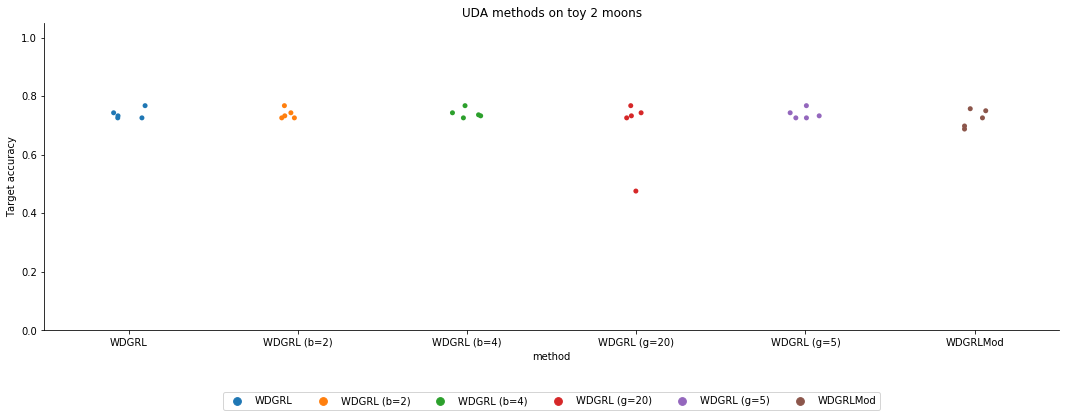

In [171]:
fig = plt.figure(figsize=(10, 5))
sns.catplot(data=test_results, x="method", y="target acc", hue="method", kind="strip", aspect=3)
#plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", borderaxespad=0., ncol=9)
plt.ylabel("Target accuracy")
plt.ylim([0, 1.05])
plt.title(f"UDA methods on {dataset_name}");

<Figure size 720x360 with 0 Axes>

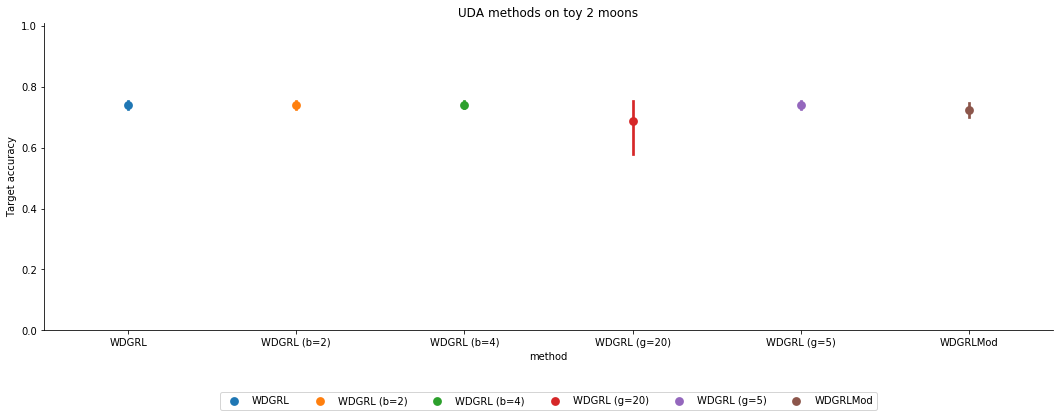

In [172]:
fig = plt.figure(figsize=(10, 5))
sns.catplot(data=test_results, x="method", y="target acc", hue="method", kind="point", aspect=3)
#plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", borderaxespad=0., ncol=9)
plt.ylabel("Target accuracy")
plt.ylim([0, 1.01])
plt.title(f"UDA methods on {dataset_name}");

## Compare methods across different hyperparameters sets

Here we can compare between any parameters, we recall which hash correspond to which parameters to select which configuration to compare. For instance, let's check the impact of changing the number of warm-up epochs (`nb_init_epochs`):

In [151]:
config_summary

,adapt_lr,lambda_init,nb_adapt_epochs,nb_init_epochs,type,betas,proba_classes,data_seed,momentum,nesterov
6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
a779d77ee1098f2fc82a60eafde1d7d0,False,1,50,10,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
c3e2c19056235bffc081e3bc512dc082,False,1,100,10,Adam,"[0.8, 0.999]",0.7,87639,NaN,NaN
a44d051dcf8ae5cdf6cb4dbc5134d02b,False,1,100,10,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
4291fcf03e83d48fe218b9795945afe7,False,1,500,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
1c32ba6fcdcca7c13649689d69ae147d,False,2,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
b4a2e816b9902b315d11422c81d1713e,True,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
b966242a3f1fb58e8aa9c3ae47be1e44,True,1,100,50,SGD,NaN,0.5,123,0.9,True


All other params equal, we keep lines 1 and 4:

In [173]:
keep_hashes_list = ["6459065f8e5cef7eb0e92d8da8725791", "a44d051dcf8ae5cdf6cb4dbc5134d02b", ]

In [174]:
dfs = []
for h in keep_hashes_list:
    res = pd.read_csv(os.path.join(output_path, dataset_name, f"{h}.csv"), index_col=0)
    res["h"] = h
    res = res.merge(params_df[useful_params], left_on="h", right_index=True)
    dfs.append(res)

df = pd.concat(dfs)
df.head()

,source acc,target acc,seed,method,split,h,adapt_lr,lambda_init,nb_adapt_epochs,nb_init_epochs,type,betas,proba_classes,data_seed,momentum,nesterov
0,1.0,0.875000,74894,Source,Validation,6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
1,1.0,0.770833,74894,Source,Test,6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
2,1.0,0.687500,54403,Source,Validation,6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
3,1.0,0.711806,54403,Source,Test,6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN
4,1.0,0.656250,86711,Source,Validation,6459065f8e5cef7eb0e92d8da8725791,False,1,100,50,Adam,"[0.8, 0.999]",0.5,123,NaN,NaN


In [175]:
test_results = df.query("split=='Test' and method in ('DANN', 'CDAN', 'WDGRL')")

<Figure size 720x360 with 0 Axes>

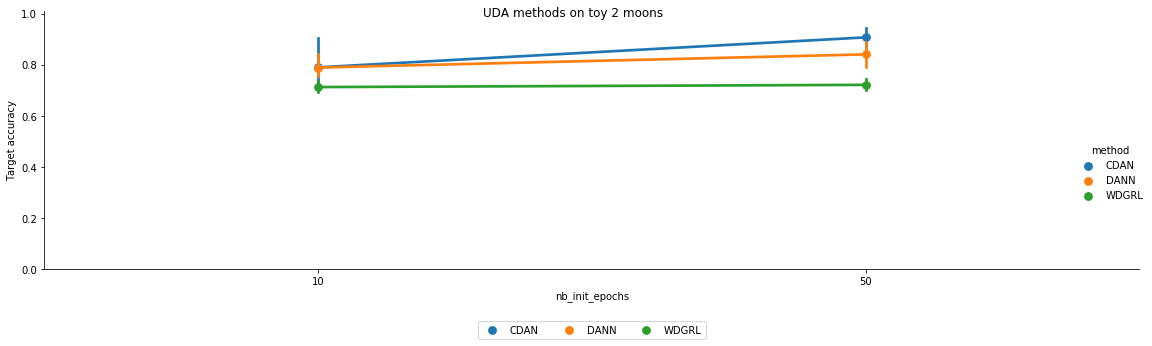

In [177]:
fig = plt.figure(figsize=(10, 5))
sns.catplot(data=test_results,y="target acc", hue="method", kind="point", x="nb_init_epochs", aspect=3)
#plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", borderaxespad=0., ncol=9)
plt.ylabel("Target accuracy")
plt.ylim([0, 1.01])
plt.suptitle(f"UDA methods on {dataset_name}")
plt.tight_layout();